# **Submission Machine Learning Terapan - Flower Classification**

## **Import Library**

Bagian kode ini digunakan untuk mengimport semua library dan modul yang diperlukan untuk mengerjakan proyek.



In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random, cv2, os, zipfile, PIL, pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

import json

import matplotlib.colors as mcolors
import pathlib

! pip install split-folders
import splitfolders

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

from tensorflow.keras.applications import ResNet101V2

from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report

## **Dataset Preparation**

Pada tahap ini, dataset yang akan digunakan untuk proyek diunduh dan dipersiapkan. Dataset berasal dari Kaggle yang berjudul **5 Flower Types Classification Dataset** yang di upload oleh KAUSTHUB KANNAN.

Dataset ini terdiri dari **lima kelas bunga yang berbeda**, yaitu Lilly, Lotus, Sunflower, Orchid, dan Tulip, dengan masing-masing kelas memiliki 1000 gambar.



In [23]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"edwinmahendraa","key":"bac357079ce9ef39f03d76d95ad91ce4"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [24]:
!kaggle datasets download kausthubkannan/5-flower-types-classification-dataset

5-flower-types-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## **Dataset Extraction**

Dataset yang telah diunduh kemudian diekstrak sehingga menghasilkan folder dengan nama `flower_images`.

In [25]:
local_zip = '5-flower-types-classification-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

## **Dataset Distribution**

Menunjukkan distribusi kelas gambar yang berbeda di dalam dataset.


Distribution of Images in the new location:
1. Lilly : 1000
2. Lotus : 1000
3. Orchid : 1000
4. Sunflower : 1000
5. Tulip : 1000





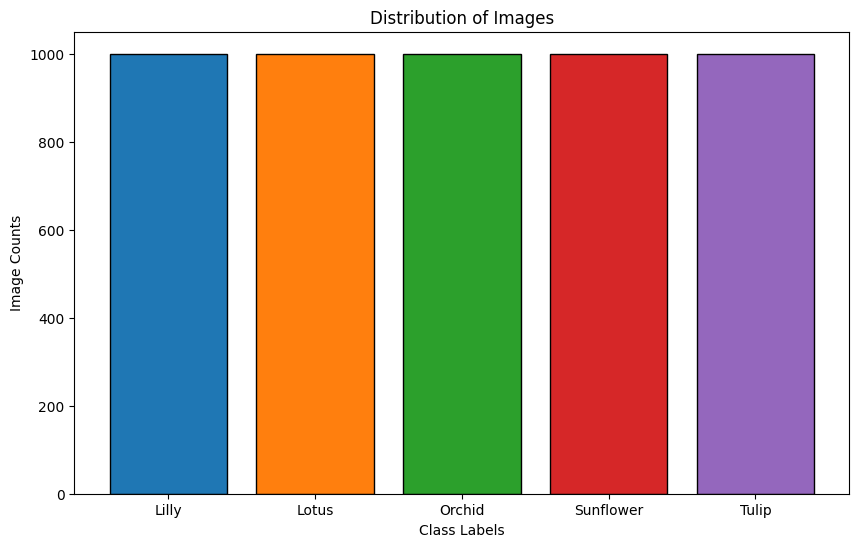

In [26]:
data_dir = pathlib.Path('./flower_images')

class_labels = []
class_counts = []

print('\nDistribution of Images in the new location:')
for i, label in enumerate(sorted(os.listdir(data_dir))):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')
    class_labels.append(label)
    class_counts.append(len_label_dir)

print('\n\n')
colors = [mcolors.TABLEAU_COLORS[key] for key in mcolors.TABLEAU_COLORS.keys()]

plt.figure(figsize=(10,6))
plt.bar(class_labels, class_counts, color=colors, edgecolor='black')
plt.ylabel('Image Counts')
plt.xlabel('Class Labels')
plt.title('Distribution of Images')
plt.show()

## **Split Dataset**

Proses berikutnya adalah pembagian dataset menjadi train, validation, dan test dataset. Pada kasus ini, data dibagi menjadi 70% untuk pelatihan, 20% untuk validasi, dan 10% untuk pengujian dengan menggunakan fungsi `splitfolders.ratio`

In [27]:
base_dir = "flower_images"
base_ds = pathlib.Path(base_dir)

splitfolders.ratio(
    base_dir,
    output = "images",
    seed = 123,
    ratio = (.7,.2,.1),
    group_prefix = None
)

Copying files: 5000 files [00:00, 5013.28 files/s]


## **Flow Train, Validation and Test Dataset**

Pada bagian ini, kita menggunakan fungsi `ImageDataGenerator` dari Keras untuk melakukan pra-pemrosesan dan augmentasi gambar. Augmentasi gambar adalah teknik yang digunakan untuk menciptakan data pelatihan baru dari data asli dengan mengubah data dengan berbagai cara. Ini membantu model dalam memahami variasi dalam data dan meningkatkan kinerja model. Selanjutnya, kita membuat generator untuk data pelatihan, validasi, dan pengujian.

In [28]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Set the paths to the data directories
train_dir = 'images/train'
val_dir = 'images/val'
test_dir = 'images/test'

data_augmentation = ImageDataGenerator(
    rescale=1./255
)

train_data = data_augmentation.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical",
                                               seed=42)

validation_data = data_augmentation.flow_from_directory(val_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=False,
                                              seed=42)

test_data = data_augmentation.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=False,
                                              seed=42)

Found 3500 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


## **Plot Data**

Di dalam satu batch gambar dari generator dan menampilkannya menggunakan matplotlib. Ketika dijalankan, kode ini akan menghasilkan **20 gambar** dengan judul yang sesuai dengan nama kelas asli dari label gambar terkait.

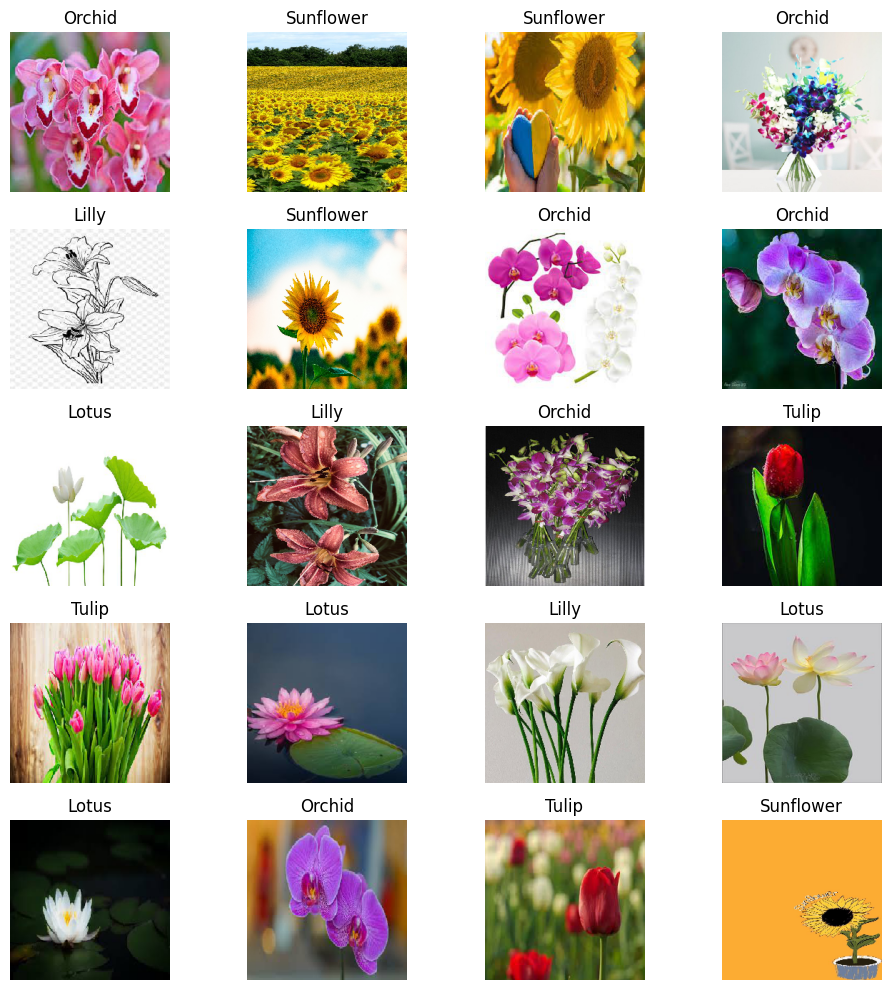

In [29]:
# Get a batch of images and labels from the train_data generator
images, labels = next(train_data)

# Get the class indices from the generator
class_indices = train_data.class_indices
# Reverse the dictionary to get the class names from the one-hot-encoded labels
class_names = {v: k for k, v in class_indices.items()}

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Build Base Model**

Pada bagian ini, arsitektur model didefinisikan. *Base Model* adalah jaringan konvolusional yang terdiri dari beberapa lapisan Conv2D dan MaxPooling2D, diikuti oleh lapisan Flatten dan Dense.

Setelah mendefinisikan model, fungsi `summary()` digunakan untuk mendapatkan gambaran umum tentang struktur model, termasuk jumlah parameter yang akan dipelajari.



In [30]:
base_model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)      

In [31]:
model_dir = "saved_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpointer = ModelCheckpoint(
    filepath = model_dir + '/base_model.hdf5',
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True
)

## **Callback**

Callback ReduceLROnPlateau akan mengurangi learning rate saat metrik tertentu berhenti membaik. Tujuannya adalah untuk menemukan learning rate yang optimal sehingga jika tidak ada peningkatan selama 'patience' epoch, learning rate akan dikurangi.

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.0001)
callbacks=[reduce_lr, checkpointer]

## **Training Base Model**

Di bagian ini, proses pelatihan model dilakukan dengan memanggil metode `fit()` pada objek model. Metode `fit() `menerima data pelatihan dan label, jumlah epoch, data validasi, dan callback.

In [33]:
history = base_model.fit(
    train_data,
    epochs=15,
    validation_data=validation_data,
    callbacks=callbacks
)

Epoch 1/15
110/110 [==============================] - ETA: 0s - loss: 1.4653 - accuracy: 0.3589
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to saved_models/base_model.hdf5
110/110 [==============================] - 33s 281ms/step - loss: 1.4653 - accuracy: 0.3589 - val_loss: 1.1996 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
110/110 [==============================] - ETA: 0s - loss: 1.2281 - accuracy: 0.4743
Epoch 2: val_accuracy improved from 0.50000 to 0.53300, saving model to saved_models/base_model.hdf5
110/110 [==============================] - 27s 246ms/step - loss: 1.2281 - accuracy: 0.4743 - val_loss: 1.1328 - val_accuracy: 0.5330 - lr: 0.0010
Epoch 3/15
110/110 [==============================] - ETA: 0s - loss: 1.0861 - accuracy: 0.5520
Epoch 3: val_accuracy improved from 0.53300 to 0.57800, saving model to saved_models/base_model.hdf5
110/110 [==============================] - 27s 248ms/step - loss: 1.0861 - accuracy: 0.5520 - val_loss: 1.0433 - val_a

## **Accuracy and Loss Graph Base Model**

Bagian ini bertujuan untuk menggambarkan perubahan akurasi dan *loss* dari model selama proses pelatihan. Pada akhir epoch, model berhasil mencapai akurasi pelatihan sebesar 98% dan akurasi validasi sebesar 83%. Namun, fungsi *loss* model semakin meningkat, yang menunjukkan bahwa model ini belum mencapai hasil yang optimal.

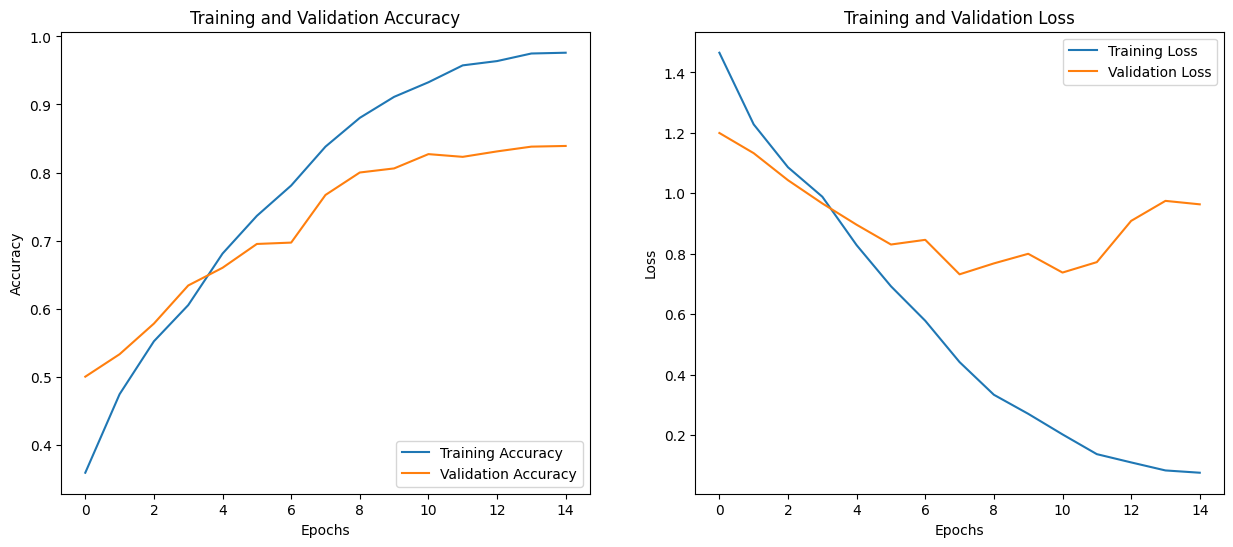

In [34]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

## **Implementasi Transfer Learning**

Karena hasil yang kurang optimal didapatkan setelah menjalankan base model, maka kita akan mencoba menerapkan transfer learning dengan menggunakan ResNet. ResNet merupakan singkatan dari "Residual Network" dan merupakan salah satu arsitektur jaringan saraf konvolusi (CNN) yang populer.

In [35]:
model_base = ResNet101V2(
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs=tf.keras.layers.Dense(5, activation="softmax",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model_resnet = tf.keras.Model(inputs=inputs, outputs=outputs)
model_resnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 42,636,805
Trainable params: 14,453,765
Non-trainable params: 28,183,040
______________________________________

## **Callback**

Digunakan 2 Callback untuk menjalankan Transfer Learning yakni `ModelCheckpoint` dan `EarlyStopping`. `ModelCheckpoint` menyimpan model setiap kali validasi loss mencapai nilai terbaik. `EarlyStopping` menghentikan pelatihan ketika metrik yang ditentukan berhenti membaik, dalam hal ini setelah validasi loss tidak menunjukkan peningkatan selama 3 epoch.

In [36]:
checkpointer = ModelCheckpoint(model_dir + '/resnet_model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)

## **Training Transfer Learning Model**

Di bagian ini, kita melakukan pelatihan pada model transfer learning yang telah kita siapkan sebelumnya dengan fungsi fit(). Model ini kemudian di-compile dengan fungsi loss 'categorical_crossentropy', optimizer 'Adam', dan metrik 'accuracy'.


In [37]:
model_resnet.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4), metrics=["accuracy"])
model_history=model_resnet.fit(x=train_data,
         steps_per_epoch=32,
         validation_data=validation_data,
         epochs=15,
         callbacks=[checkpointer, early_stopping])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


32/32 [==============================] - ETA: 0s - loss: 1.0412 - accuracy: 0.6152
Epoch 1: val_loss improved from inf to 0.45174, saving model to saved_models/resnet_model.hdf5
32/32 [==============================] - 24s 562ms/step - loss: 1.0412 - accuracy: 0.6152 - val_loss: 0.4517 - val_accuracy: 0.8610
Epoch 2/15
32/32 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8740
Epoch 2: val_loss did not improve from 0.45174
32/32 [==============================] - 15s 461ms/step - loss: 0.4021 - accuracy: 0.8740 - val_loss: 0.5440 - val_accuracy: 0.8440
Epoch 3/15
32/32 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9258
Epoch 3: val_loss improved from 0.45174 to 0.27838, saving model to saved_models/resnet_model.hdf5
32/32 [==============================] - 15s 471ms/step - loss: 0.2870 - accuracy: 0.9258 - val_loss: 0.2784 - val_accuracy: 0.9180
Epoch 4/15
32/32 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.943

## **Accuracy and Loss Graph ResNet**

Setelah melalui proses pelatihan, diperoleh hasil akurasi dan loss menggunakan ResNet. Hasilnya sangat mengesankan, dengan akurasi mencapai 99% untuk data pelatihan dan >94% untuk data validasi. Selain itu, nilai loss yang dicapai juga sangat kecil, hanya sebesar 18%.



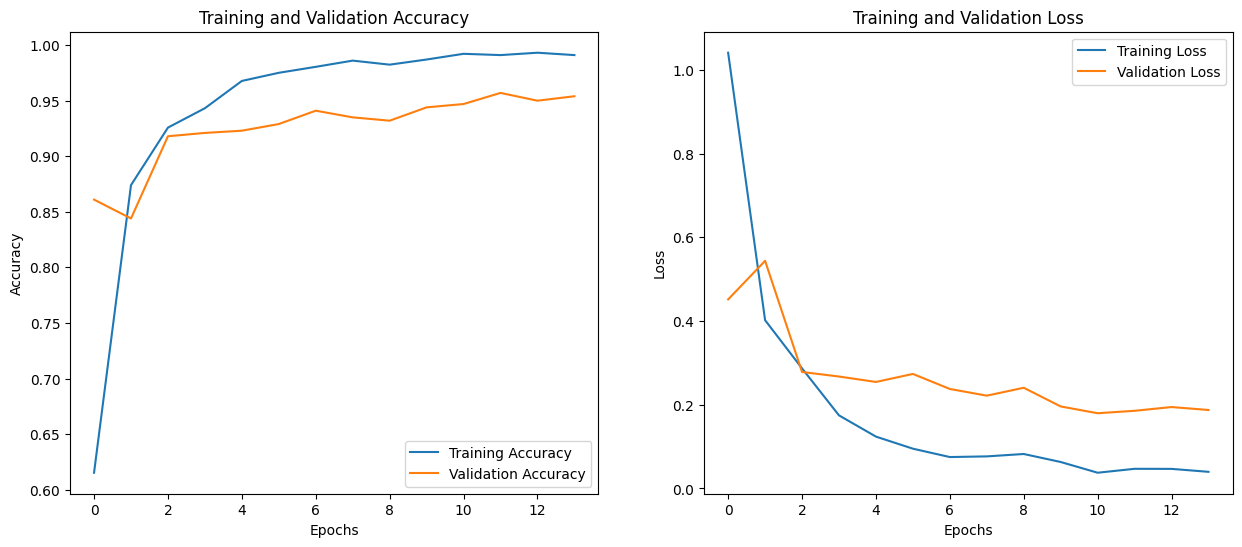

In [38]:
# Extract the training history
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(15, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

## **Model Evaluation**

Di bagian ini, kita mengevaluasi performa dari model dasar dan model transfer learning pada data uji dengan fungsi evaluate(). Fungsi ini mengembalikan loss dan metrik yang didefinisikan saat model dikompilasi.

In [39]:
base_model_score = base_model.evaluate(test_data, verbose=1)
resnet_model_score = model_resnet.evaluate(test_data, verbose=1)

print("Base Model Loss      : ", base_model_score[0])
print("Accuracy Base Model  : ", base_model_score[1]*100)
print()
print("Model ResNet Loss     : ", resnet_model_score[0])
print("Accuracy ResNet Model : ", resnet_model_score[1]*100)

16/16 [==============================] - 4s 207ms/step - loss: 0.1658 - accuracy: 0.9580
Base Model Loss      :  0.8013201951980591
Accuracy Base Model  :  85.39999723434448

Model ResNet Loss     :  0.16583648324012756
Accuracy ResNet Model :  95.80000042915344


Berdasarkan hasil yang ditampilkan, model yang dibuat memiliki hasil sebagai berikut:
*   **Model Dasar (Base Model)** memiliki nilai loss **0.8013** dan tingkat akurasi sebesar **85.39%**.
*   **Model Transfer Learning** dengan arsitektur ResNet memiliki nilai loss **0.1658** dan tingkat akurasi sebesar **95.8%**.

Dapat disimpulkan bahwa Model Transfer Learning dengan arsitektur ResNet memberikan performa yang lebih baik dibandingkan dengan Model Dasar. Hal ini ditunjukkan dari nilai loss yang lebih rendah dan akurasi yang lebih tinggi pada Model Transfer Learning.

## **Testing Model**






### **Testing with Test Dataset Images**

Pada bagian ini dilakukan pengujian prediksi 3 gambar bunga acak yang ada pada test dataset dengan label sebenarnya

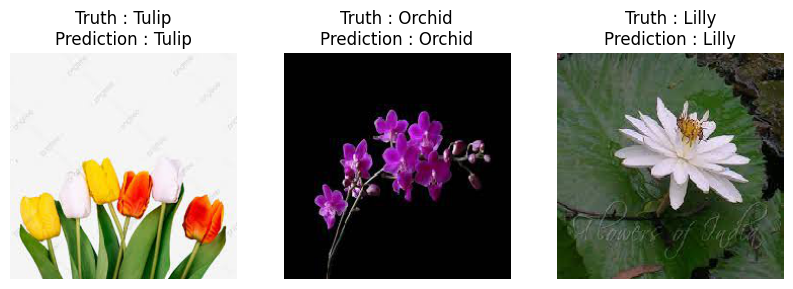

In [40]:
plt.figure(figsize=(10, 10))
x, label= train_data.next()
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_resnet(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = class_labels[np.argmax(score)]
    plt.title("Truth : " + class_labels[result[0][0]] + "\nPrediction : " + score_label)
    plt.axis(False)

### **Classification Report for Base Model**



In [41]:
print("Classification Report for Base Model")

# Assuming you have a generator called test_data
test_labels = test_data.classes

# Convert the labels to one-hot encoded format
num_classes = len(test_data.class_indices)
y_true_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

# Obtain predictions from model_resnet
y_pred = base_model.predict(test_data)

# Get the predicted labels and create the classification report
class_names_test = list(test_data.class_indices.keys())
y_pred_labels = np.argmax(y_pred, axis=1)
report = classification_report(np.argmax(y_true_labels, axis=1), y_pred_labels, target_names=class_names_test)

print(report)

Classification Report for Base Model
16/16 [==============================] - 3s 184ms/step
              precision    recall  f1-score   support

       Lilly       0.81      0.78      0.80       100
       Lotus       0.84      0.81      0.82       100
      Orchid       0.80      0.88      0.84       100
   Sunflower       0.94      0.97      0.96       100
       Tulip       0.88      0.83      0.86       100

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



### **Classification Report for ResNet Model**



In [42]:
print("Classification Report for ResNet Model")

# Assuming you have a generator called test_data
test_labels = test_data.classes

# Convert the labels to one-hot encoded format
num_classes = len(test_data.class_indices)
y_true_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

# Obtain predictions from model_resnet
y_pred = model_resnet.predict(test_data)

# Get the predicted labels and create the classification report
class_names_test = list(test_data.class_indices.keys())
y_pred_labels = np.argmax(y_pred, axis=1)
report = classification_report(np.argmax(y_true_labels, axis=1), y_pred_labels, target_names=class_names_test)

print(report)

Classification Report for ResNet Model
16/16 [==============================] - 5s 198ms/step
              precision    recall  f1-score   support

       Lilly       0.95      0.88      0.91       100
       Lotus       0.96      0.98      0.97       100
      Orchid       0.96      0.98      0.97       100
   Sunflower       0.99      0.99      0.99       100
       Tulip       0.93      0.96      0.95       100

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

